#  GAN as Image Generator #

In [2]:
########### Basic Data Handling Import Set ###########
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Other:
import random
import os
import PIL
import time
from IPython import display

In [ ]:
########### Tensorflow Import ###########

# ON CONDA: pip install tensorflow==2.0.0-alpha0 # If any problem -> pip uninstall numpy -> pip install numpy
import tensorflow as tf
from tensorflow.keras import layers, models

## Data Load ##

In [4]:
# Data format: 60000 clothes images 28x28

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# Normalização entre -1 e 1
train_images = (train_images - 127.5) / 127.5

buffer_size = 60000
batch_size = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

print(train_dataset)

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


## Data Visualization ##

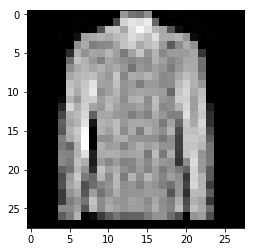

In [6]:
plt.imshow(train_images[112].reshape((28,28)) , cmap = 'gray')

## Generator Build Up ##

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # 12544
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    # 7x7x128
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 14x14x64
    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 28x28x1
    model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))

    model.summary()

    return model

In [8]:
noise = tf.random.normal([1, 100])

In [9]:
generator = make_generator_model()
generated_image = generator(noise, training = False)
print(generated_image.shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_v2 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

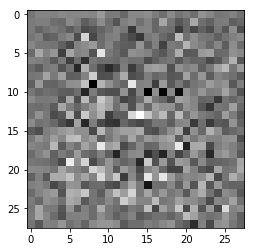

In [10]:
plt.imshow(generated_image[0,:,:,0], cmap='gray');

## Discriminator Build Up ##

In [11]:
def make_discrimator_model():
    model = tf.keras.Sequential()
    # 14x14x64
    model.add(layers.Conv2D(64, (5,5), strides = (2,2), padding='same', input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 7x7x128
    model.add(layers.Conv2D(128, (5,5), strides = (2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 6272
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    model.summary()

    return model

In [12]:
discriminator = make_discrimator_model()
decision = discriminator(generated_image, training = False)
print(decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

## Loss Function for Models ##

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # 0.00001
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # 0.00001

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer,
                                 generator=generator, discriminator=discriminator)

## Model Training ##

In [18]:
epochs = 100
noise_dim = 100
num_examples_to_generate = 16

In [19]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])
print(seed.shape)
print(batch_size)

(16, 100)
256


In [20]:
@tf.function
def train_steps(images):
    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Chamar o gerador e passar os números aleatórios
        generated_images = generator(noise, training = True)

        # Passar para o discriminador as imagens reais e falsas para fazer a classificação
        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        # Calcular a loss para o gerador e discriminador
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calcular o gradiente das losses para atualizar os pesos
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Aplicar os otimizadores e atualizar os pesos
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [21]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_steps(image_batch)

        display.clear_output(wait = True)
        generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    display.clear_output(wait = True)
    generate_and_save_images(generator, epoch + 1, seed) 

In [22]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training = False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

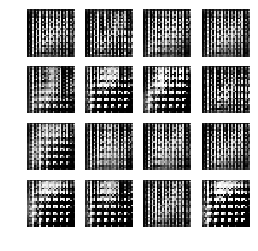

Time for epoch 2 is 709.7281274795532 sec


KeyboardInterrupt: 

In [24]:
train(train_dataset, epochs)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [25]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

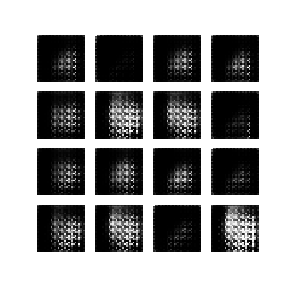

In [26]:
display_image(1)